# Anomaly Detection using fbProphet

In [1]:
!pip install fbprophet

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [4]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
df = df.set_index('timestamp').resample('H').mean()

In [7]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5


In [8]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi demand')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label='1y', step='year', stepmode='backward'),
                      dict(count=2, label='3y', step='year', stepmode='backward'),
                      dict(count=3, label='5y', step='year', stepmode='backward'),
                      dict(step='all')
                    ])
    )

)

fig.show()

In [9]:
from fbprophet import Prophet

In [10]:
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 'value':'y'}, axis='columns')

In [11]:
taxi_df.head()

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


In [12]:
train = taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] <= '2015-01-27')]
test = taxi_df[(taxi_df['ds'] > '2015-01-27')] 

In [13]:
train.shape

(5041, 2)

In [14]:
test.shape

(119, 2)

In [15]:
m = Prophet(changepoint_range=0.95)

In [16]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [17]:
future = m.make_future_dataframe(periods=119, freq='H')
future.tail(5)

,ds
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00
5159,2015-01-31 23:00:00


In [18]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23778.529213,19101.611849,28489.983433
5156,2015-01-31 20:00:00,24342.584334,19805.216776,29080.992044
5157,2015-01-31 21:00:00,23219.297735,18514.201784,28088.884149
5158,2015-01-31 22:00:00,21027.355314,16417.474254,25684.817539
5159,2015-01-31 23:00:00,18500.216845,13632.252008,23001.559207


In [19]:
results = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]], axis=1)

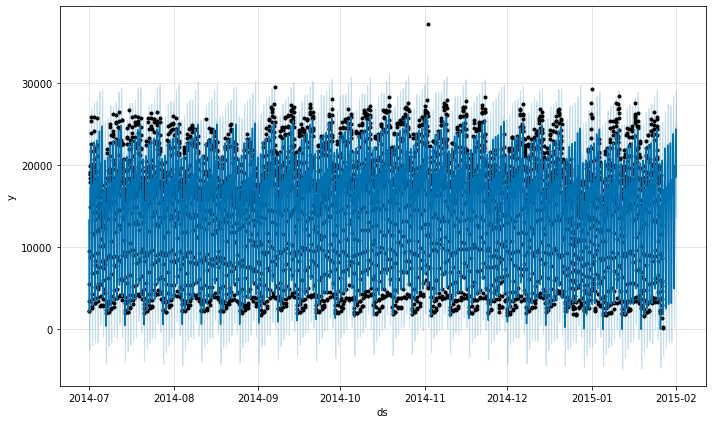

In [20]:
fig1 = m.plot(forecast)

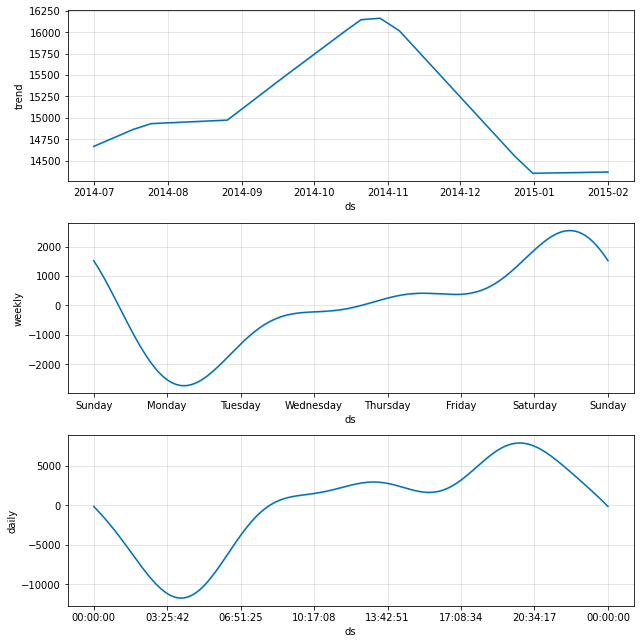

In [21]:
comp=m.plot_components(forecast)

In [22]:
results['error'] = results['y'] - results['yhat']

In [23]:
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

In [24]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis=1)

In [25]:
results[results['anomaly'] == 'Yes']

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9785.434316,19335.417699,22985.607130,9549.983383,Yes
2015-01-01 01:00:00,29292.0,11405.545567,6492.889490,15762.152736,17886.454433,9269.263246,Yes
2015-01-01 02:00:00,25753.5,7770.054639,3165.394346,12004.970633,17983.445361,8839.576287,Yes
2015-01-01 03:00:00,22067.0,4478.895177,-169.736006,9399.970395,17588.104823,9569.706401,Yes
2015-01-26 19:00:00,4565.5,19771.308307,14784.770443,24443.347937,-15205.808307,9658.577494,Yes
2015-01-26 20:00:00,3630.5,20546.581743,15875.969951,25227.215497,-16916.081743,9351.245546,Yes
2015-01-26 21:00:00,2907.0,19647.710004,14867.935087,24366.639448,-16740.710004,9498.704361,Yes
2015-01-26 22:00:00,1324.5,17691.969234,12801.032175,22224.202216,-16367.469234,9423.170041,Yes
2015-01-26 23:00:00,243.0,15411.348672,10344.453269,20097.289404,-15168.348672,9752.836135,Yes


In [45]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi demand')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label='1y', step='year', stepmode='backward'),
                      dict(count=2, label='3y', step='year', stepmode='backward'),
                      dict(count=3, label='5y', step='year', stepmode='backward'),
                      dict(step='all')
                    ])
    )

)

fig.show()

# Anomaly Detection using Isolation Forest

Unsupervised method of anomaly detection. It isolates the anomalies.
It builds an ensemble of isolation trees.  

In [27]:
from sklearn.ensemble import IsolationForest

In [29]:
df = df.reset_index()

In [30]:
df

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [31]:
df['hour'] = df.timestamp.dt.hour

In [32]:
df['weekday'] = pd.Categorical(df.timestamp.dt.strftime('%A'), categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

In [33]:
df.head(10)

,timestamp,value,hour,weekday
0,2014-07-01 00:00:00,9485.5,0,Tuesday
1,2014-07-01 01:00:00,5433.0,1,Tuesday
2,2014-07-01 02:00:00,3346.5,2,Tuesday
3,2014-07-01 03:00:00,2216.5,3,Tuesday
4,2014-07-01 04:00:00,2189.5,4,Tuesday
5,2014-07-01 05:00:00,3439.5,5,Tuesday
6,2014-07-01 06:00:00,8782.5,6,Tuesday
7,2014-07-01 07:00:00,14861.0,7,Tuesday
8,2014-07-01 08:00:00,19133.0,8,Tuesday
9,2014-07-01 09:00:00,19823.0,9,Tuesday


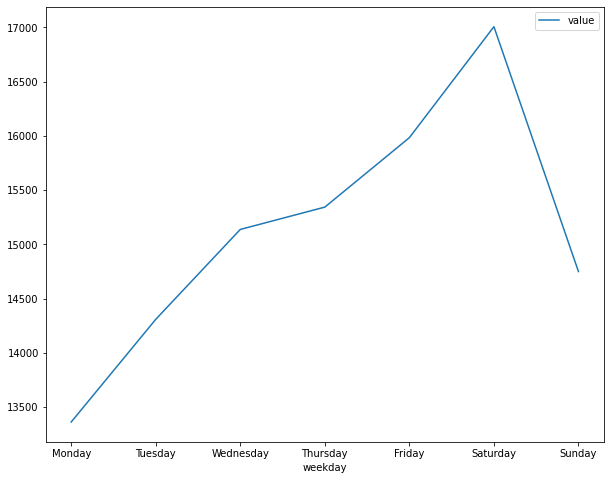

In [34]:
df[['value', 'weekday']].groupby('weekday').mean().plot()

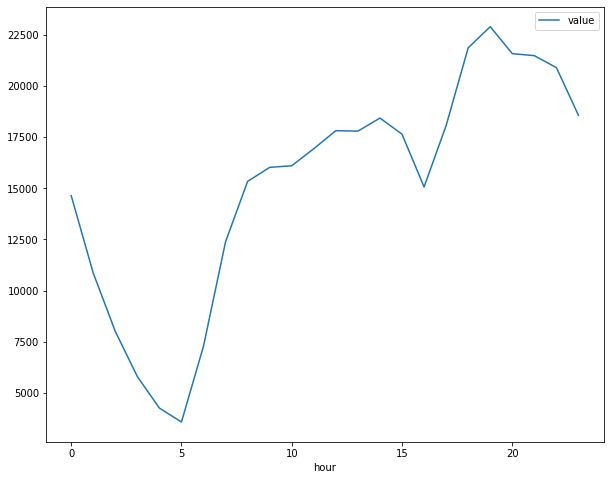

In [35]:
df[['value', 'hour']].groupby('hour').mean().plot()

In [36]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi demand')


fig.update_xaxes(
    rangeslider_visible=True
    )
fig.show()

In [37]:
model = IsolationForest(contamination=0.004)
model.fit(df[['value']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.004,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [41]:
df['outliers'] = pd.Series(model.predict(df[['value']])).apply(lambda x: 'yes' if(x == -1) else 'no')

In [42]:
df.query('outliers=="yes"')

,timestamp,value,hour,weekday,outliers
1630,2014-09-06 22:00:00,27414.0,22,Saturday,yes
1631,2014-09-06 23:00:00,29418.5,23,Saturday,yes
1942,2014-09-19 22:00:00,27385.5,22,Friday,yes
2135,2014-09-27 23:00:00,28024.5,23,Saturday,yes
2639,2014-10-18 23:00:00,28253.5,23,Saturday,yes
2807,2014-10-25 23:00:00,27554.5,23,Saturday,yes
2971,2014-11-01 19:00:00,27912.0,19,Saturday,yes
2977,2014-11-02 01:00:00,37204.5,1,Sunday,yes
3118,2014-11-07 22:00:00,27471.0,22,Friday,yes
3143,2014-11-08 23:00:00,27926.0,23,Saturday,yes


In [44]:
fig = px.scatter(df.reset_index(), x='timestamp', y='value', color='outliers', hover_data=['weekday'],title='NYC Taxi demand')


fig.update_xaxes(
    rangeslider_visible=True)

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:286: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [51]:
model = IsolationForest()
model.fit(df[['value']])
core = model.decision_function(df[['value']])

(array([  1.,   2.,   4.,   1.,   2.,   2.,   4.,   5.,   9.,   3.,   1.,
          2.,   7.,   5.,   1.,   2.,   7.,   9.,  20.,  11.,   7.,  22.,
         19.,   8.,  28.,  11.,  24.,  69.,  95., 100., 247., 195., 166.,
        215., 397., 238., 272., 335., 267., 337., 105., 205., 164., 125.,
        148., 179., 138., 390., 203., 353.]),
 array([-0.04855727, -0.04238572, -0.03621418, -0.03004263, -0.02387108,
        -0.01769954, -0.01152799, -0.00535644,  0.0008151 ,  0.00698665,
         0.0131582 ,  0.01932974,  0.02550129,  0.03167284,  0.03784438,
         0.04401593,  0.05018748,  0.05635902,  0.06253057,  0.06870212,
         0.07487366,  0.08104521,  0.08721676,  0.0933883 ,  0.09955985,
         0.1057314 ,  0.11190294,  0.11807449,  0.12424604,  0.13041758,
         0.13658913,  0.14276068,  0.14893222,  0.15510377,  0.16127531,
         0.16744686,  0.17361841,  0.17978995,  0.1859615 ,  0.19213305,
         0.19830459,  0.20447614,  0.21064769,  0.21681923,  0.22299078,
 

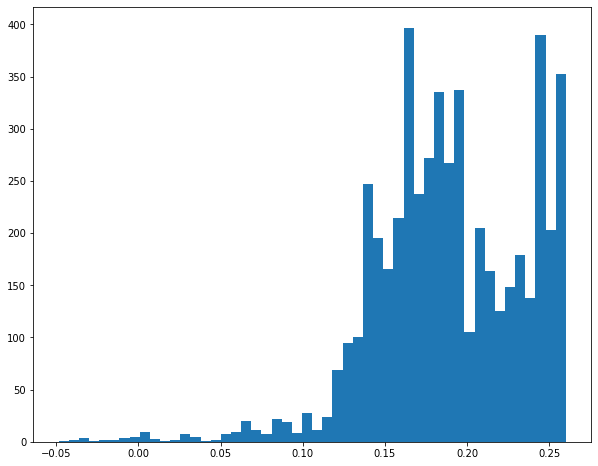

In [52]:
plt.hist(score, bins = 50)

In [53]:
df['scores'] = score

In [56]:
df.query('scores < 0.25')

,timestamp,value,hour,weekday,outliers,scores
0,2014-07-01 00:00:00,9485.5,0,Tuesday,no,0.154555
1,2014-07-01 01:00:00,5433.0,1,Tuesday,no,0.143010
2,2014-07-01 02:00:00,3346.5,2,Tuesday,no,0.190754
3,2014-07-01 03:00:00,2216.5,3,Tuesday,no,0.131820
4,2014-07-01 04:00:00,2189.5,4,Tuesday,no,0.130623
...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,yes,-0.031787
5156,2015-01-31 20:00:00,24138.0,20,Saturday,no,0.162231
5157,2015-01-31 21:00:00,24194.5,21,Saturday,no,0.158211
5158,2015-01-31 22:00:00,26515.0,22,Saturday,no,0.082817
